In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gensim
from sklearn.cluster import KMeans

In [2]:
# from https://leetcode.com/problems/random-pick-with-weight/discuss/357379/o1-python-alias-sampling
import random
class Alias_Pick(object):
  
    def __init__(self, w):
      """
      :type w: List[int]
      """
      self.probs = self.__gen_probs(w)
      self.alias = self.__gen_alias(self.probs)
        
    def __gen_probs(self, w):
      total = sum(w)
      return [v*1./total*len(w) for v in w]
        
    def __gen_alias(self, ps):
      alias = [i for i in range(len(ps))]
      small, large = [], []
      for i, p in enumerate(ps):
        if p < 1: small.append(i)
        else: large.append(i)
      while small and large:
        s,l = small.pop(), large.pop()
        ps[l] -= 1 - ps[s]
        alias[s] = l
        if ps[l] < 1: small.append(l)
        else: large.append(l)
      return alias
    
    def pickIndex(self):
        """
        :rtype: int
        """
        rand_loc  = random.randint(0, len(self.probs)-1)
        rand_prob = random.random()
        return rand_loc if rand_prob <= self.probs[rand_loc] else self.alias[rand_loc]

In [3]:
G = nx.read_gml('lesmis.gml')

In [4]:
G = nx.read_gml('lesmis.gml')

w = np.zeros((len(G), len(G)))
for x in range(len(G.nodes)):
    for v in range(len(G.nodes)):
        if G.get_edge_data(x, v):
            print(type(G.get_edge_data(x,v)['value']))
            w[x][v] = int(G.get_edge_data(x,v)['value'])
        else:
            w[x][v] = int(0)
w

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
w = np.zeros((len(G), len(G)))

w[0][0] = 1
w

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
def node2vecWalk(G, u, l, p, q):
    """
    G: Graph
    u: start node
    l: num of steps
    """
    walk_list = [u]
    t = None
    for i in range(1, l):
        prob_dic = {}
        curr = walk_list[i-1]
        # to deal with first step which doesnt have previous node
        if t is None:
            t = curr
        else:
            t = walk_list[i-2]
        # get neighbors x 
        neighbors_dict = nx.single_source_shortest_path_length(G, u, cutoff=1)
        # get distance between t and x, change transition probability accordingly
        for x, dist in neighbors_dict.items():
            dist_tx = nx.shortest_path_length(G, t, x)
            if dist_tx == 0:
                alpha = 1/p
                if G.get_edge_data(u, x):
                    prob_dic[x] = (alpha * G.get_edge_data(u, x)['value'])
            elif dist_tx == 1:
                alpha = 1
                if G.get_edge_data(u, x):
                    prob_dic[x] = (alpha * G.get_edge_data(u, x)['value'])
            elif dist_tx == 2:
                alpha = 1/q
                if G.get_edge_data(u, x):
                    prob_dic[x] = (alpha * G.get_edge_data(u, x)['value'])
            else:
                continue
        # normalize 
        factor = 1.0/sum(prob_dic.values())
        for k in prob_dic:
            prob_dic[k] = prob_dic[k]*factor

        # take step according to pi
        idx = Alias_Pick(prob_dic.values()).pickIndex()
        s = list(prob_dic)[idx] # choose node value from dictionary based on alias sampled index
        # add new node u
        walk_list.append(s)
        # change previous node t
        t = u
    return walk_list

In [22]:
def learn_embeddings(walks, d, k):
	'''
	Learn embeddings by optimizing the Skipgram objective using SGD.
	'''
	#walks = [map(str, walk) for walk in walks]
	return gensim.models.Word2Vec(sentences=walks, vector_size=d, window=k)

In [23]:
def learn_features(G, d=128, r=10, l=80, k=10, p=1, q=0.25):
    """
    G: Graph
    d: Dimensions
    r: walks per node
    l: walk length
    k: context size
    p: return
    q: in-out
    """
    walks = []
    for i in range(r):
        for u in G.nodes:
            walk = node2vecWalk(G, u, l, p, q)
            walks.append(walk)
    return learn_embeddings(walks, d, k)

In [24]:
G = nx.read_gml('lesmis.gml')
model = learn_features(G, d=16, r=10, l=10, k=10, p=1, q=0.5)

In [25]:
node2vecWalk(G, "Myriel", l=20, p=0.5, q=0.5)

['Myriel',
 'MmeMagloire',
 'MmeMagloire',
 'Valjean',
 'MmeMagloire',
 'MmeMagloire',
 'MmeMagloire',
 'OldMan',
 'MlleBaptistine',
 'Valjean',
 'Geborand',
 'MlleBaptistine',
 'MlleBaptistine',
 'MlleBaptistine',
 'Napoleon',
 'Valjean',
 'Valjean',
 'MmeMagloire',
 'CountessDeLo',
 'MmeMagloire']

In [38]:
def visualize_embedding(model, n_clusters=6):
    G = nx.les_miserables_graph()
    vecs = []
    for node in G:
        vecs.append(model.wv[node])
    X = np.stack(vecs, axis=0)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    colormap = kmeans.labels_
    # plotting
    plt.figure(figsize =(30, 15))
    node_size = [(len(list(G.neighbors(i)))+1)*100 for i in G.nodes()]
    node_pos = nx.spring_layout(G)
    nx.draw_networkx(G, font_size=15, node_color=colormap, with_labels = True, node_size=node_size, pos = node_pos)
    
    plt.show()

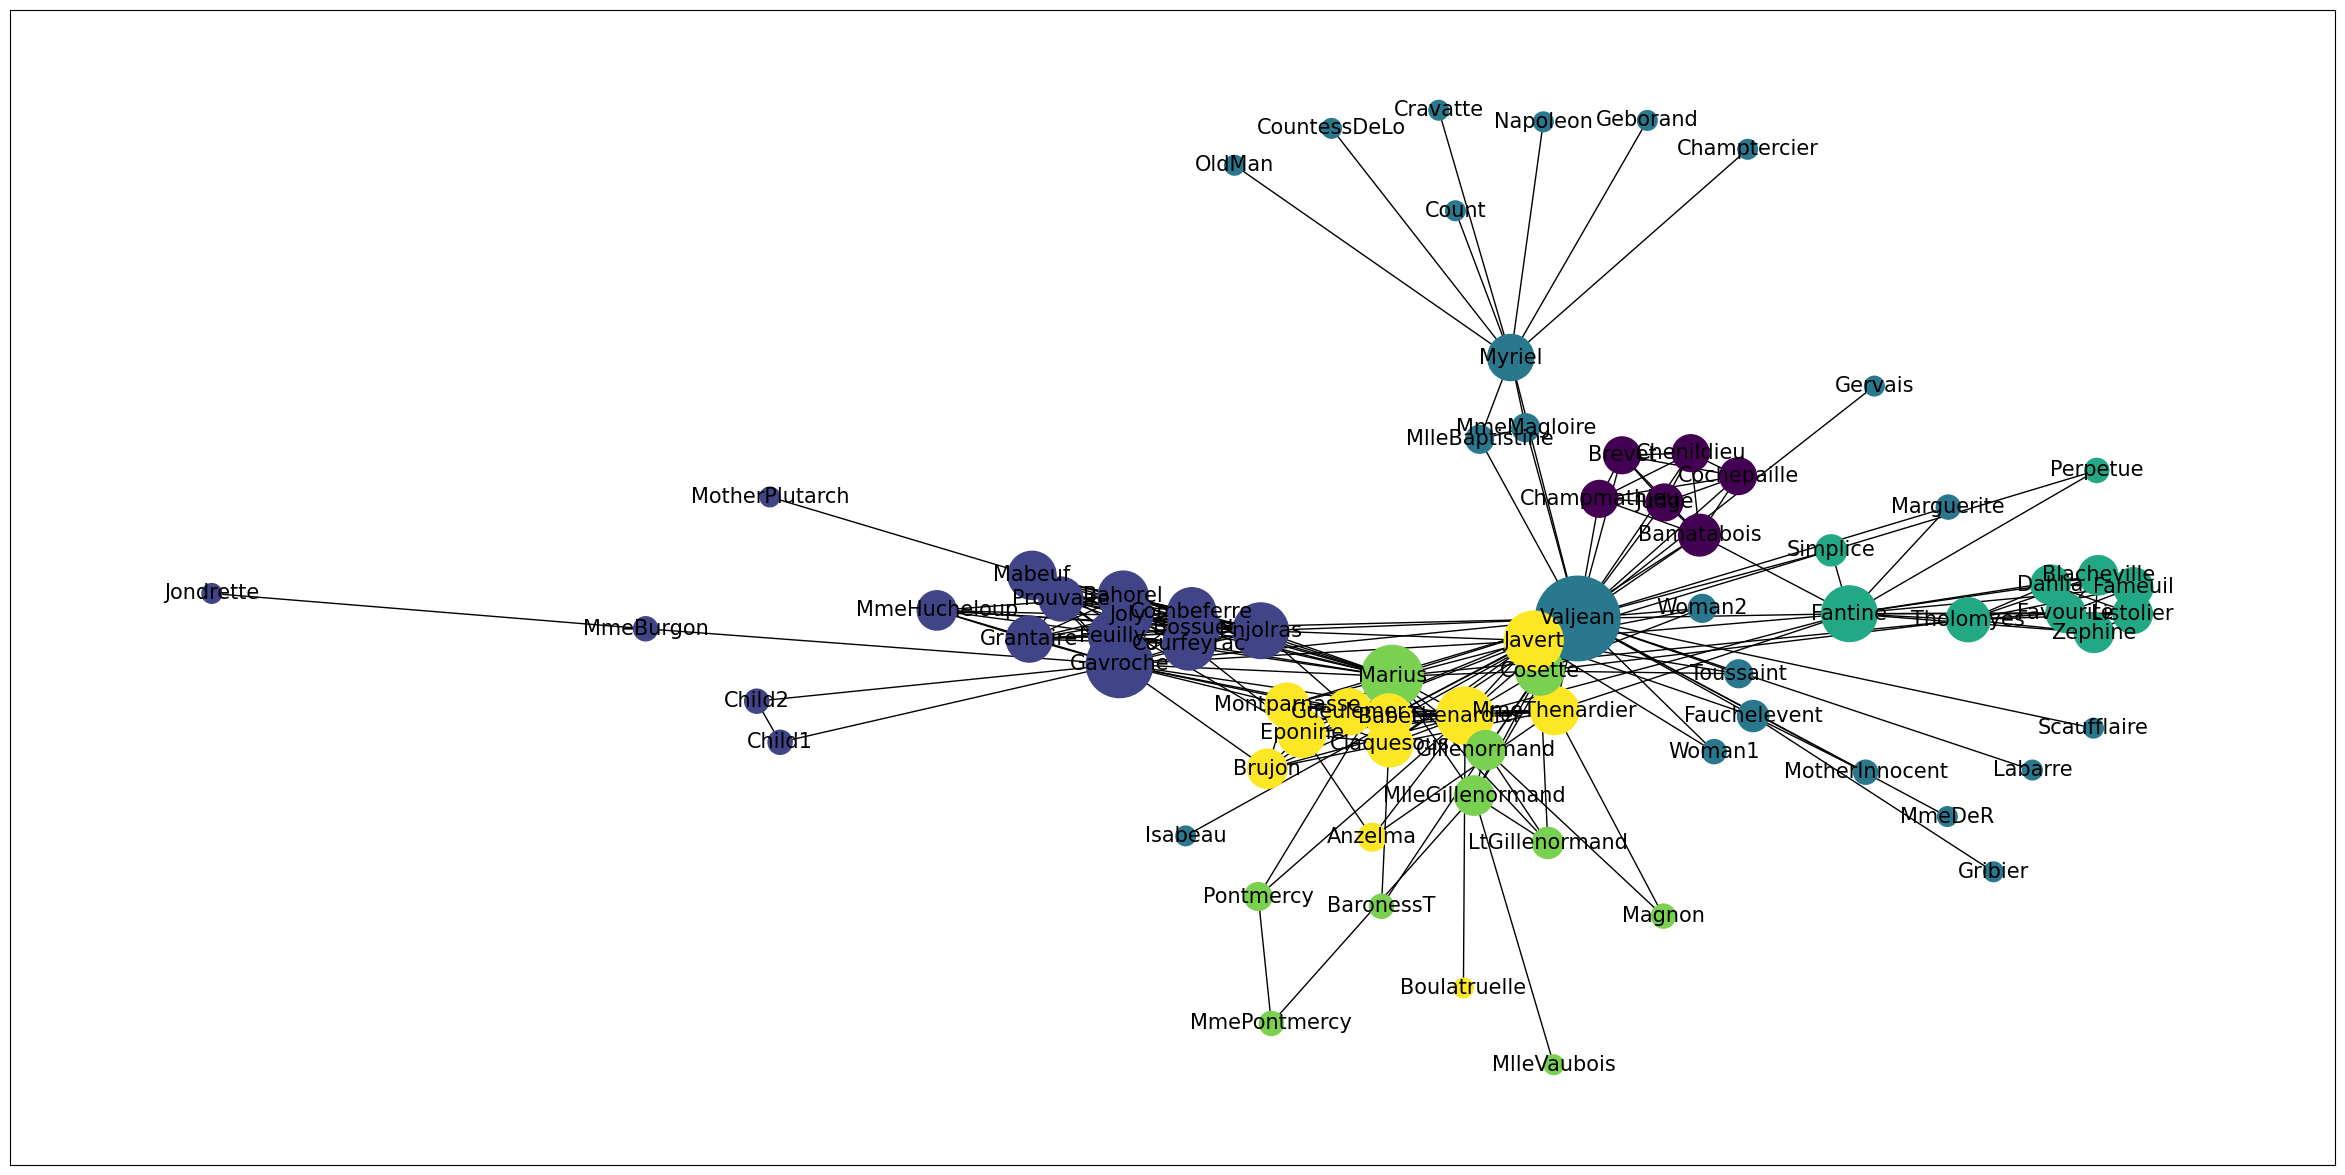

In [39]:
# Visualize Homophily

G = nx.read_gml('lesmis.gml')

model = learn_features(G, d=64, r=40, l=20, k=8, p=1, q=0.5)

visualize_embedding(model, n_clusters=6)

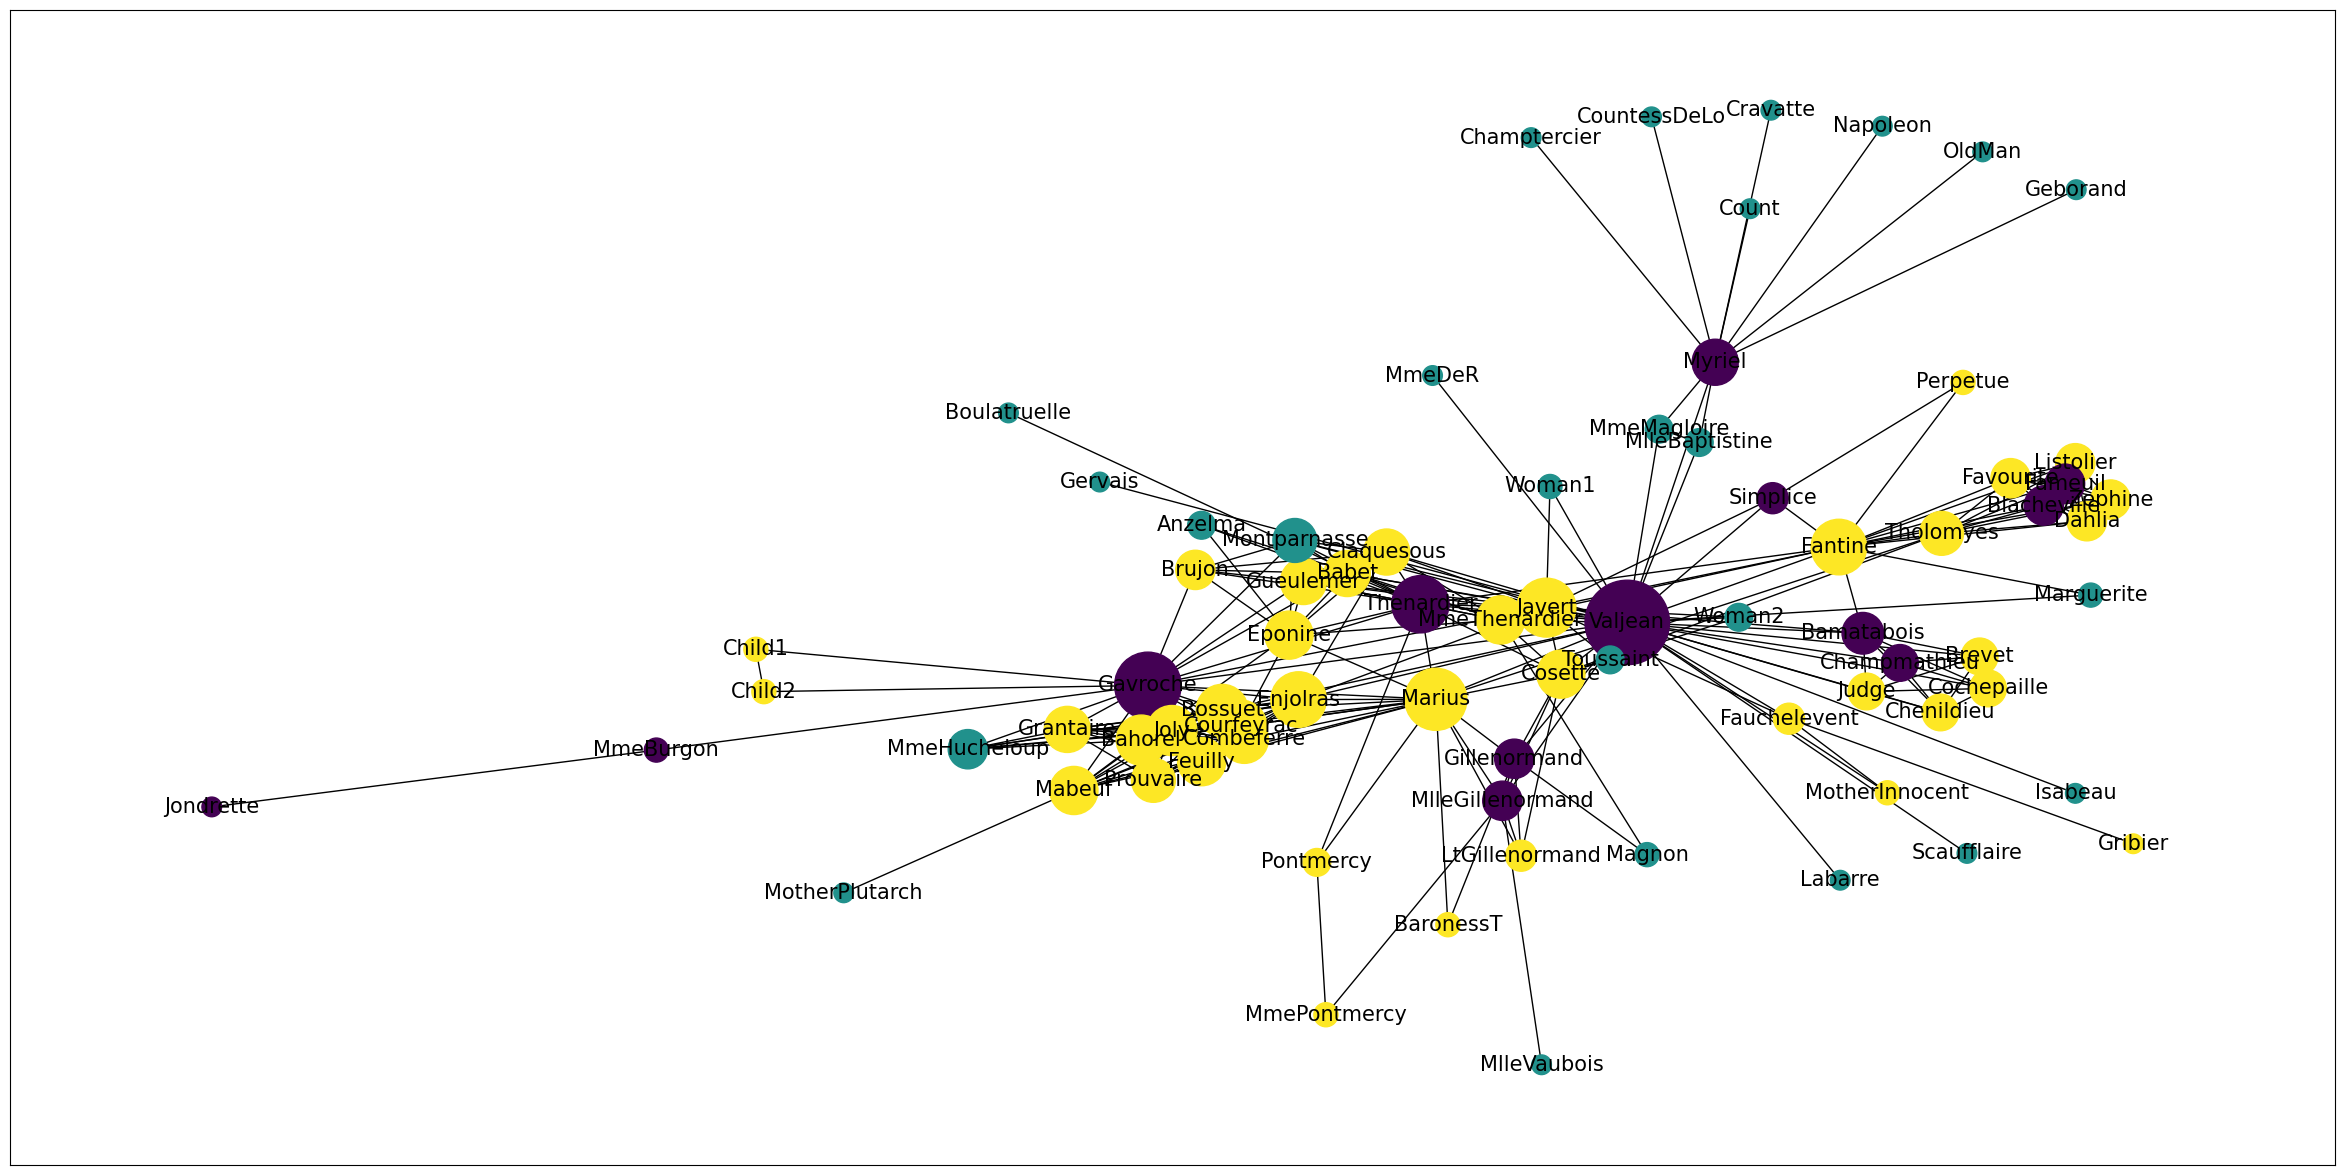

In [40]:
# Visualize Structural Equivalence

model = learn_features(G, d=64, r=10, l=4, k=8, p=1, q=2)
    
visualize_embedding(model, n_clusters=3)